<a href="https://colab.research.google.com/github/swicklund/hackathon/blob/main/MLModel1_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -Uqq fastbook
!pip install dtreeviz
!gcloud config set project {'hackathon-352519'}

import os

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import fastbook as fastai
import pandas as pd
from pandas.io.json import json_normalize
import seaborn as sns
import tensorflow as tf
import json
import zipfile
from io import BytesIO
import torch
import math
from google.colab import files
from google.colab import auth
from datetime import datetime, timedelta

fastai.setup_book()
from fastai import tabular


     |████████████████████████████████| 719 kB 14.5 MB/s 
     |████████████████████████████████| 362 kB 79.2 MB/s 
     |████████████████████████████████| 4.4 MB 14.3 MB/s 
     |████████████████████████████████| 1.2 MB 17.3 MB/s 
     |████████████████████████████████| 1.1 MB 63.1 MB/s 
     |████████████████████████████████| 212 kB 27.5 MB/s 
     |████████████████████████████████| 101 kB 12.7 MB/s 
     |████████████████████████████████| 140 kB 72.1 MB/s 
     |████████████████████████████████| 596 kB 66.2 MB/s 
     |████████████████████████████████| 127 kB 66.9 MB/s 
     |████████████████████████████████| 94 kB 4.1 MB/s 
     |████████████████████████████████| 144 kB 61.4 MB/s 
     |████████████████████████████████| 271 kB 62.6 MB/s 
     |████████████████████████████████| 6.6 MB 60.4 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datascience 0.1

In [2]:
from pandas.api.types import is_string_dtype, is_numeric_dtype, is_categorical_dtype
from fastai.tabular.all import *
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from dtreeviz.trees import *
from IPython.display import Image, display_svg, SVG

pd.options.display.max_rows = 20
pd.options.display.max_columns = 8

In [3]:
auth.authenticate_user()

In [4]:
# !gcloud config set project {'hackathon-352519'}

In [5]:
#filename = "train-data_all-train-events.zip"
#filename = "train-data-2022062020220626.zip"
filename = "train-events-20-min.zip"

In [6]:
!gsutil cp gs://trains_data/$filename /tmp/.

Copying gs://trains_data/train-events-20-min.zip...
- [1 files][ 40.7 MiB/ 40.7 MiB]                                                
Operation completed over 1 objects/40.7 MiB.                                     


In [7]:
trains = {}
i = 1
# prevLoco = ''
with zipfile.ZipFile("/tmp/"+filename, "r") as f:
    for name in f.namelist():
        if name.endswith('.json'):
            with f.open(name) as zd:
                data = json.load(zd)
                lastTrainReporting = data['lastTrainReporting']
                currentLoco = lastTrainReporting['ptcLeadLocomotiveId']
                # prevLoco != currentLoco and 
                if ("trainActualPositionList" in lastTrainReporting and len(lastTrainReporting['trainActualPositionList']) > 0): 
                    # trainActualPositionList = lastTrainReporting['trainActualPositionList']
                    trains[i] = pd.json_normalize(lastTrainReporting)
                    i = i + 1
                    if (i % 1000 == 0):
                      current_time = datetime.now().strftime("%H:%M:%S")
                      print(i, " ", current_time)
                    # prevLoco = currentLoco
                            

1000   03:09:10
2000   03:09:20
3000   03:09:24
4000   03:09:29
5000   03:09:33
6000   03:09:37


In [8]:
dfTrainsAll = pd.concat(trains.values())
dfTrainsAll["milepost"] = dfTrainsAll.apply(lambda row: math.trunc(row['lastReportedPosition.milepostLocation.milepost.milepostNumber']), axis=1)

In [9]:
del trains

In [10]:
print(dfTrainsAll.info())
print(dfTrainsAll.shape)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6747 entries, 0 to 0
Data columns (total 37 columns):
 #   Column                                                         Non-Null Count  Dtype  
---  ------                                                         --------------  -----  
 0   ptcLeadLocomotiveId                                            6747 non-null   object 
 1   positionHistoryList                                            6747 non-null   object 
 2   locomotiveList                                                 6747 non-null   object 
 3   subdivisionList                                                6747 non-null   object 
 4   trainEstimatedPositionList                                     6747 non-null   object 
 5   trainActualPositionList                                        6747 non-null   object 
 6   trainId.trainSCAC                                              6747 non-null   object 
 7   trainId.trainSection                                           

In [11]:
dfTrainsLearn = dfTrainsAll

In [12]:
dfTrainsLearn['loadedCarCount'] =  dfTrainsLearn['loadedCarCount'].replace(np.nan, 999.)
dfTrainsLearn['emptyCarCount'] =  dfTrainsLearn['emptyCarCount'].replace(np.nan, 999.)
dfTrainsLearn['trainLength'] =  dfTrainsLearn['trainLength'].replace(np.nan, 99999.)
dfTrainsLearn['trailingTonnage'] =  dfTrainsLearn['trailingTonnage'].replace(np.nan, 99999.)
# print(dfTrainsLearn['trailingTonnage'].unique())

In [13]:
dfTrainsLearn['mpIncr'] = dfTrainsLearn.apply(lambda row: row['lastReportedPosition.speedMPH'] >= 0, axis=1)

In [14]:
dfTrainsLearn['lastReportedPosition.speedMPH']  = dfTrainsLearn.apply(lambda row: abs(row['lastReportedPosition.speedMPH']), axis=1)
dfTrainsLearn['maximumTrainSpeed']  = dfTrainsLearn.apply(lambda row: abs(row['maximumTrainSpeed']), axis=1)

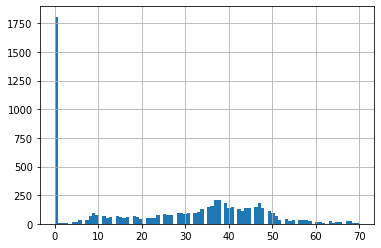

In [15]:
dfTrainsLearn['lastReportedPosition.speedMPH'].hist(bins=90)

In [16]:
aotuColumns = [item for item in dfTrainsLearn.columns if item.startswith('aotu')]
for column in aotuColumns:
  dfTrainsLearn[column] =  dfTrainsLearn[column].replace(np.nan, 0.)

In [17]:
def categorize(aDataFrame, columnName, defaultReplacement):
  aDataFrame[columnName] = aDataFrame[columnName].fillna(value=defaultReplacement)
  categories = aDataFrame[columnName].unique()
  print(aDataFrame[columnName].unique())
  aDataFrame[columnName] = aDataFrame[columnName].astype('category')
  aDataFrame[columnName] = aDataFrame[columnName].cat.set_categories(categories)
  return aDataFrame

In [18]:
# dfTrainsLearn[['lastReportedPosition.milepostLocation.trackName']] = dfTrainsLearn[['lastReportedPosition.milepostLocation.trackName']].fillna(value="UNKNOWN")
# tracks = dfTrainsLearn['lastReportedPosition.milepostLocation.trackName'].unique().dropna()
# print(pd.Series(tracks)) 
# dfTrainsLearn['lastReportedPosition.milepostLocation.trackName'] = dfTrainsLearn['lastReportedPosition.milepostLocation.trackName'].cat.set_categories(tracks)

In [19]:
dfTrainsLearn['symbolType'] = dfTrainsLearn.apply(lambda row: row['trainId.trainSymbol'][:1], axis=1)
dfTrainsLearn = categorize(dfTrainsLearn, 'symbolType', "X")
dfTrainsLearn = categorize(dfTrainsLearn, 'lastReportedPosition.milepostLocation.trackName', "UNKNOWN")
dfTrainsLearn = categorize(dfTrainsLearn, 'trainId.trainSCAC',"UNK")
dfTrainsLearn = categorize(dfTrainsLearn, 'trainId.trainSection', ' ')
dfTrainsLearn = categorize(dfTrainsLearn, 'aotuTrainData.priorityCode', 0)  # may want to order these
dfTrainsLearn = categorize(dfTrainsLearn, 'aotuTrainData.categoryCode', 0)
dfTrainsLearn = categorize(dfTrainsLearn, 'aotuTrainData.authorityRangeCode', 0)
dfTrainsLearn = categorize(dfTrainsLearn, 'aotuTrainData.ownershipCode', 0)
dfTrainsLearn = categorize(dfTrainsLearn, 'aotuTrainData.tenantCarrier', "0")
dfTrainsLearn = categorize(dfTrainsLearn, 'aotuTrainData.eventCode', 0)
 

['A' 'Q' 'M' 'H' 'G' 'U' 'I' 'O' 'E' 'C' 'Y' 'L' 'Z' 'S' 'R' 'W']
['TO_S_UP_MAINLINE' 'WEST MAIN' 'EAST MAIN' 'TO_N_EAST MAIN' 'MAIN' 'S_LUCAS' 'NEW LACY TRACK' 'MAIN CHAISON YARD' 'MT 2' 'MT 1' 'S_VIDOR' 'TO_S_VIDOR' 'TO_S_CS JUNCTION' 'S_HELME' 'EASTXO'
 'TO_S_KCS UP PRT CONN' 'KCS UP PORT CONNECT' 'WESTXO' 'N SIDING' 'XO' 'TO_N_HELME' 'TO_N_CHAISON MAIN' 'TO_N_LUCAS' 'TO_N_STARKS' 'S_STARKS' 'S_MAURICEVILLE' 'TO_S_LUCAS' 'TO_N_MAURICEVILLE' 'YD LD'
 'TO_N_VIDOR' 'S_FISHER' 'S_CONVERSE' 'S_ANACOCO' 'S_NEAME' 'S_LEESVILLE']
['UP']
['' '2' '3' '4' '5']
[1. 2. 0. 4. 3.]
[14. 12.  0.  9.  8. 10. 18. 15.  4. 20. 11.  2. 17. 16. 13. 19.]
[2. 0. 3. 1.]
[3. 0. 2.]
['AMTK' 'BNSF' 0.0 '' 'KCS']
[0.]


In [20]:
dfTrainsLearn['lastReportedPosition.milepostLocation.trackName'] = dfTrainsLearn['lastReportedPosition.milepostLocation.trackName'].astype('category')
dfTrainsLearn['lastReportedPosition.milepostLocation.trackName'] = dfTrainsLearn['lastReportedPosition.milepostLocation.trackName'].cat.set_categories(['WEST MAIN', 'MAIN', 'MT 2', 'MT 1', 'WESTXO', 'XO', 'EASTXO','YD LD', 'EAST MAIN', 'TO_N_EAST MAIN', 'TO_S_UP_MAINLINE', 'TO_S_CS JUNCTION', 'S_STARKS', 'TO_S_KCS UP PRT CONN', 'TO_N_LUCAS', 'S_LUCAS'])
#dfTrainsLearn['lastReportedSpeedMPH'] = dfTrainsLearn.apply(lambda row: row['positionHistoryList'][0]['speedMPH'], axis=1)
# dfTrainsLearn['symbolType'] = dfTrainsLearn['symbolType'].astype('category')
# dfTrainsLearn['symbolType'] = dfTrainsLearn['symbolType'].cat.set_categories(['A' 'Q' 'M' 'H' 'G' 'U' 'O' 'I' 'E' 'C' 'Y' 'L' 'Z' 'S' 'R' 'W'])


In [21]:
dfTrainsLearn['maximumTrainSpeed'] =  dfTrainsLearn['maximumTrainSpeed'].replace(np.nan, 88.)
print(dfTrainsLearn['maximumTrainSpeed'].unique())

[88. 50. 60. 70. 40. 45. 30.]


In [22]:
def getWorkLocations(dfTrainsLocation):
  if isinstance(dfTrainsLocation['aotuTrainData.routeLocationList'], float):
    return None
  if len(dfTrainsLocation['aotuTrainData.routeLocationList']) == 0:
    return None
  aotuRoute=pd.json_normalize(dfTrainsLocation['aotuTrainData.routeLocationList']) 
  eventLocations = aotuRoute[aotuRoute['activityList'].map(len) > 1]
  temp = eventLocations['milepost.milepostNumber'].unique()
  if len(temp) == 0:
    return None
  return ','.join(['%.2f' % num for num in temp])

In [23]:
# routeLoca = dfTrainsLearn.loc[dfTrainsLearn['aotuTrainData.routeLocationList'].str.len() > 0]['aotuTrainData.routeLocationList']
# route = routeLoca.iloc[0]
# print(route)
# jsroute = pd.json_normalize(route)
# jsroute

In [24]:
# dfTrainsLearn.loc[dfTrainsLearn['aotuTrainData.routeLocationList'].map(len)==0]
# dfTrainsLearn[dfTrainsLearn['aotuTrainData.routeLocationList'].apply(lambda x: isinstance(x, float))]['aotuTrainData.routeLocationList']

In [25]:
dfTrainsLearn['workLocations'] = dfTrainsLearn.apply(lambda row: getWorkLocations(row), axis=1)

In [26]:
dfTrainsLearn['workLocations'].unique()

array([None, '202.20', '225.10', '202.20,219.70', '202.20,258.40,321.50', '202.20,258.40', '219.70,202.20', '250.50,202.20', '258.40,202.20', '258.40,207.60,202.20', '321.50,202.20', '202.20,314.52',
       '202.20,214.50,225.10,290.80,304.10', '214.50,225.10,290.80,304.10,202.20', '321.50,314.52,202.20', '258.40,219.70,202.20', '314.52,202.20', '257.60,202.20', '202.20,265.30',
       '202.20,258.40,318.90,321.50', '202.20,219.70,258.40,321.50', '202.20,219.70,250.50,258.40,321.50', '258.40,214.50,202.20', '202.20,219.70,258.40', '225.10,202.20'], dtype=object)

We can make this more clever later, but for now this seems the most sensible shortcut

In [27]:
dfTrainsLearn['locomotiveCount'] = dfTrainsLearn.apply(lambda row: len(row['locomotiveList']),axis = 1)

In [28]:
dfTrainsLearnActuals = dfTrainsLearn.apply(lambda row: pd.json_normalize(row['trainActualPositionList']), axis=1)

In [29]:
dfTrainsLearnActuals.iloc[1]

,positionTime,speedMPH,milepostLocation.subdivisionId,milepostLocation.trackName,milepostLocation.milepost.milepostNumber
0,2022-06-29T21:49:20Z,13,106,MAIN,765.37634
1,2022-06-29T21:53:20Z,19,106,EAST MAIN,766.58430


In [30]:
dfTrainsBeop =  dfTrainsLearn[['lastReportedPosition.milepostLocation.milepost.milepostNumber','trainEstimatedPositionList']]
dfTrainsBeop

,lastReportedPosition.milepostLocation.milepost.milepostNumber,trainEstimatedPositionList
0,764.8696,[]
0,764.8706,[]
0,766.9310,[]
0,764.8691,[]
0,766.9302,[]
...,...,...
0,290.7408,"[{'positionTime': '2022-06-23T10:15:47Z', 'speedMPH': 12, 'milepostLocation': {'subdivisionId': 106, 'trackName': 'EASTXO', 'milepost': {'milepostNumber': 290.7408}}}, {'positionTime': '2022-06-23T10:17:47Z', 'speedMPH': 30, 'milepostLocation': {'subdivisionId': 106, 'trackName': 'EASTXO', 'milepost': {'milepostNumber': 291.4418}}}, {'positionTime': '2022-06-23T10:19:47Z', 'speedMPH': 40, 'milepostLocation': {'subdivisionId': 106, 'trackName': 'EASTXO', 'milepost': {'milepostNumber': 292.6651}}}, {'positionTime': '2022-06-23T10:21:47Z', 'speedMPH': 49, 'milepostLocation': {'subdivisionId':..."
0,293.2164,[]
0,294.0817,"[{'positionTime': '2022-06-23T11:17:23Z', 'speedMPH': 23, 'milepostLocation': {'subdivisionId': 106, 'trackName': 'MT 2', 'milepost': {'milepostNumber': 294.0817}}}, {'positionTime': '2022-06-23T11:19:23Z', 'speedMPH': 35, 'milepostLocation': {'subdivisionId': 106, 'trackName': 'MT 2', 'milepost': {'milepostNumber': 295.03876}}}, {'positionTime': '2022-06-23T11:21:23Z', 'speedMPH': 45, 'milepostLocation': {'subdivisionId': 106, 'trackName': 'MT 2', 'milepost': {'milepostNumber': 296.39496}}}, {'positionTime': '2022-06-23T11:23:23Z', 'speedMPH': 50, 'milepostLocation': {'subdivisionId': 106..."
0,305.3550,"[{'positionTime': '2022-06-23T11:34:06Z', 'speedMPH': 48, 'milepostLocation': {'subdivisionId': 106, 'trackName': 'MT 1', 'milepost': {'milepostNumber': 305.355}}}, {'positionTime': '2022-06-23T11:36:06Z', 'speedMPH': 50, 'milepostLocation': {'subdivisionId': 106, 'trackName': 'MT 1', 'milepost': {'milepostNumber': 307.01364}}}, {'positionTime': '2022-06-23T11:38:06Z', 'speedMPH': 50, 'milepostLocation': {'subdivisionId': 106, 'trackName': 'MT 1', 'milepost': {'milepostNumber': 308.68835}}}, {'positionTime': '2022-06-23T11:40:06Z', 'speedMPH': 50, 'milepostLocation': {'subdivisionId': 106,..."


In [31]:
dfTrainsLearn = dfTrainsLearn.reset_index(drop=True)

In [32]:
def findNextMilepost(trainsEntry, actualsEntry):
  currMilepost = trainsEntry['lastReportedPosition.milepostLocation.milepost.milepostNumber']
  value  = actualsEntry.loc[actualsEntry['milepostLocation.milepost.milepostNumber'] > currMilepost+1]
  if (len(value) > 0) :
    return value[value['milepostLocation.milepost.milepostNumber'] == value['milepostLocation.milepost.milepostNumber'].min()]
  value  = actualsEntry.loc[actualsEntry['milepostLocation.milepost.milepostNumber'] < currMilepost-1]
  if (len(value) > 0):
    return value[value['milepostLocation.milepost.milepostNumber'] == value['milepostLocation.milepost.milepostNumber'].max()]
  return []

In [33]:
def findNextSpeed(trainsEntry, actualsEntry):
  nextActual = findNextMilepost(trainsEntry, actualsEntry)
  if (len(nextActual) > 0):
    amt = (abs(nextActual.iloc[0]['speedMPH']) - abs(trainsEntry['lastReportedPosition.speedMPH']))
    return amt;
  return None

In [34]:
idx = 3291
print(dfTrainsLearn.iloc[idx]['ptcLeadLocomotiveId'])
print(dfTrainsLearn.iloc[idx]['trainId.trainSymbol'])
print("Reported speed: ", dfTrainsLearn.iloc[idx]['lastReportedPosition.speedMPH'])
print("Reported MP: ", dfTrainsLearn.iloc[idx]['lastReportedPosition.milepostLocation.milepost.milepostNumber'])
print("Reported Time: ", dfTrainsLearn.iloc[idx]['lastReportedPosition.positionTime'])

nextActual = findNextMilepost(dfTrainsLearn.iloc[idx], dfTrainsLearnActuals.iloc[idx])
print(nextActual)
nextSpeed = findNextSpeed(dfTrainsLearn.iloc[idx], dfTrainsLearnActuals.iloc[idx])
print("actual speed: ",nextSpeed)
beopJSON = dfTrainsBeop.iloc[idx]['trainEstimatedPositionList']
if not type(beopJSON) is float and len(beopJSON) > 0:
  beopDT = pd.json_normalize(beopJSON)
  nextBeop = findNextMilepost(dfTrainsLearn.iloc[idx], beopDT)
  print(nextBeop)
  type(dfTrainsBeop.iloc[idx]['trainEstimatedPositionList'])
  print("beop speed: ")
  value = findNextSpeed(dfTrainsLearn.iloc[idx], beopDT)
  print(value)
#   print('na')

UP6579
CNAPW9
Reported speed:  42
Reported MP:  315.8773
Reported Time:  2022-06-26T02:15:16Z
           positionTime  speedMPH  milepostLocation.subdivisionId  \
0  2022-06-26T02:17:16Z       -43                             106   

  milepostLocation.trackName  milepostLocation.milepost.milepostNumber  
0                       MT 2                                 314.40375  
actual speed:  1
           positionTime  speedMPH  milepostLocation.subdivisionId  \
1  2022-06-26T02:17:16Z       -44                             106   

  milepostLocation.trackName  milepostLocation.milepost.milepostNumber  
1                       MT 2                                  314.4466  
beop speed: 
2


In [35]:
dfTrainsLearn['nextSpeed'] = np.NaN
dfTrainsLearn['nextBeop'] = np.NaN
i = 0;
for index, trainsEntry in dfTrainsLearn.iterrows():
  nextSpeed = findNextSpeed(trainsEntry, dfTrainsLearnActuals.iloc[i])
  if (nextSpeed != None):
    dfTrainsLearn.at[i,'nextSpeed'] = nextSpeed
  beopJSON = dfTrainsBeop.iloc[i]['trainEstimatedPositionList']
  if not type(beopJSON) is float and len(beopJSON) > 0:
    try:
      beopDT = pd.json_normalize(beopJSON)
      nextBeop = findNextSpeed(trainsEntry, beopDT)
      if (nextBeop != None):
        dfTrainsLearn.at[i,'nextBeop'] = nextSpeed
    except NotImplementedError:
      print(type(beopJSON))
    except KeyError:
      print(beopJSON)
  if (i % 1000 == 0):
    print(i)
  i = i + 1

0
1000
2000
3000
4000
5000
6000


In [36]:
dfTrainsLearn['nextSpeed'].unique()

array([ nan,   8.,   5.,   9.,   2.,  -4.,  10.,  -1.,   4.,  13.,   0.,   6.,   1.,  12.,  22.,  24.,  -3.,   7.,  16.,  17.,  -2.,   3.,  -8.,  25.,  -5., -21., -10.,  15.,  -7.,  19.,  21.,  18.,
        14., -11.,  20.,  23.,  32.,  11.,  -6., -13., -14.,  28., -20.,  26., -34.,  27., -15., -12.,  31.,  30.,  -9., -19.,  34.,  37.,  40., -18.,  41.,  38.,  33.,  29.,  36., -22.,  45.,  44.,
        46., -17., -28.,  39.,  68.,  35., -27.,  65.,  49., -32., -16., -43., -24., -39.,  42., -31., -23., -25., -29.,  43., -33.,  54., -30.,  53., -26.])

In [37]:
dfTrainsLearn = dfTrainsLearn.dropna(subset=['nextSpeed'])
dfTrainsLearn['nextSpeed'].unique()

array([  8.,   5.,   9.,   2.,  -4.,  10.,  -1.,   4.,  13.,   0.,   6.,   1.,  12.,  22.,  24.,  -3.,   7.,  16.,  17.,  -2.,   3.,  -8.,  25.,  -5., -21., -10.,  15.,  -7.,  19.,  21.,  18.,  14.,
       -11.,  20.,  23.,  32.,  11.,  -6., -13., -14.,  28., -20.,  26., -34.,  27., -15., -12.,  31.,  30.,  -9., -19.,  34.,  37.,  40., -18.,  41.,  38.,  33.,  29.,  36., -22.,  45.,  44.,  46.,
       -17., -28.,  39.,  68.,  35., -27.,  65.,  49., -32., -16., -43., -24., -39.,  42., -31., -23., -25., -29.,  43., -33.,  54., -30.,  53., -26.])

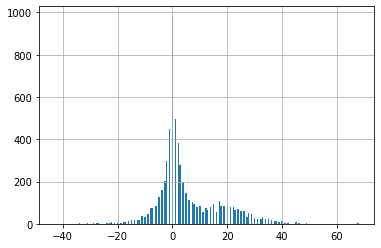

In [38]:
dfTrainsLearn['nextSpeed'].hist(bins=200)

In [39]:
dfTrainsLearn['nextBeop'].unique()

array([ nan,   1.,   2.,   0.,  -1.,   4.,   3.,  -3.,   6.,  -5.,   5., -21.,  12., -10.,  -7.,  -2.,   9.,  10., -14.,  14., -20.,   8.,  -4.,  20., -34.,  -6., -15.,  -8., -12., -11.,  18.,  17.,
        -9., -19.,  11.,  13.,   7.,  15., -18., -13.,  23.,  21., -22., -17.,  16., -28.,  28.,  33., -27.,  27.,  30.,  19.,  46.,  26.,  35., -32., -16.,  39., -43., -24.,  25., -39.,  24.,  22.,
       -31., -23.,  34., -25.,  40.,  31., -29., -33., -30., -26.])

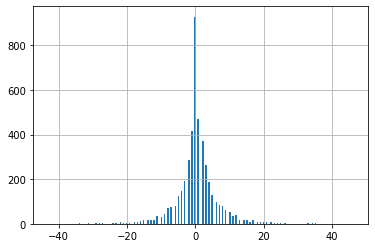

In [40]:
dfTrainsLearn['nextBeop'].hist(bins=200)

Drop some values we are not using at the moment not needed

In [41]:
dfTrainsNextBeop = dfTrainsLearn['nextBeop']

In [42]:
dfTrainsLearn = dfTrainsLearn.drop(columns=['aotuTrainData.tenantCarrier',
                                            'nextBeop',
                                            # 'lastReportedPosition.precedingSignalState.currentStateTime', 
                                            # 'lastReportedPosition.nextSignalState.previousSignalState', 
                                            # 'lastReportedPosition.nextSignalState.currentStateTime', 
                                            'positionHistoryList',
                                            'locomotiveList',
                                            'subdivisionList',
                                            'trainActualPositionList',
                                            'trainEstimatedPositionList',
                                            'aotuTrainData.routeLocationList'])

In [43]:
tabular.core.make_date(dfTrainsLearn, 'trainId.trainDate')
tabular.core.make_date(dfTrainsLearn, 'lastReportedPosition.positionTime')
tabular.core.add_datepart(dfTrainsLearn, 'lastReportedPosition.positionTime')
# tabular.core.add_elapsed_times(dfTrainsLearn, 'lastReportedPosition.positionTime')


,ptcLeadLocomotiveId,trainId.trainSCAC,trainId.trainSection,trainId.trainSymbol,...,lastReportedPosition.positionTimeIs_quarter_start,lastReportedPosition.positionTimeIs_year_end,lastReportedPosition.positionTimeIs_year_start,lastReportedPosition.positionTimeElapsed
1,AMTK179,UP,,AMT1,...,False,False,False,1.656539e+09
2,AMTK179,UP,,AMT2,...,False,False,False,1.656462e+09
3,AMTK186,UP,,AMT1,...,False,False,False,1.655938e+09
4,AMTK186,UP,,AMT2,...,False,False,False,1.655857e+09
5,AMTK19,UP,,AMT2,...,False,False,False,1.656109e+09
...,...,...,...,...,...,...,...,...,...
6742,UP9101,UP,,MCHCB,...,False,False,False,1.655979e+09
6743,UP9101,UP,,MCHCB,...,False,False,False,1.655982e+09
6744,UP9101,UP,,MCHCB,...,False,False,False,1.655983e+09
6745,UP9101,UP,,MCHCB,...,False,False,False,1.655984e+09


In [44]:
print(dfTrainsLearn.shape)
print(dfTrainsLearnActuals.shape)

print(dfTrainsLearn.info())
print(dfTrainsLearn.iloc[100])

(6250, 47)
(6747,)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 6250 entries, 1 to 6746
Data columns (total 47 columns):
 #   Column                                                         Non-Null Count  Dtype         
---  ------                                                         --------------  -----         
 0   ptcLeadLocomotiveId                                            6250 non-null   object        
 1   trainId.trainSCAC                                              6250 non-null   category      
 2   trainId.trainSection                                           6250 non-null   category      
 3   trainId.trainSymbol                                            6250 non-null   object        
 4   trainId.trainDate                                              6250 non-null   datetime64[ns]
 5   lastReportedPosition.speedMPH                                  6250 non-null   int64         
 6   lastReportedPosition.milepostLocation.subdivisionId            6250 non-null 

# Use Decision Tree to predict speed in 1 mile

In [45]:
procs = [tabular.core.Categorify, tabular.core.FillMissing]

In [46]:
print (dfTrainsLearn.groupby(['lastReportedPosition.positionTimeDayofyear'])['lastReportedPosition.positionTimeDayofyear'].count())


lastReportedPosition.positionTimeDayofyear
171    487
172    517
173    505
174    660
175    599
176    569
177    589
178    565
179    567
180    530
181    526
182    136
Name: lastReportedPosition.positionTimeDayofyear, dtype: int64


In [69]:
cond = ( dfTrainsLearn['lastReportedPosition.positionTimeDayofyear'] < 179 )
trainIdx = np.where(cond)[0]
validIdx = np.where(~cond)[0]
splits = (list(trainIdx), list(validIdx))

In [70]:
dep_var = 'nextSpeed'

In [71]:
cont,cat = tabular.core.cont_cat_split(dfTrainsLearn, 1, dep_var=dep_var)

In [72]:
to = tabular.core.TabularPandas(dfTrainsLearn, procs, cat, cont, y_names=dep_var, splits=splits)

In [73]:
len(to.train),len(to.valid)

(4491, 1759)

In [74]:
to.show()

,ptcLeadLocomotiveId,trainId.trainSCAC,trainId.trainSection,trainId.trainSymbol,trainId.trainDate,lastReportedPosition.milepostLocation.subdivisionId,lastReportedPosition.milepostLocation.trackName,aotuTrainData.priorityCode,aotuTrainData.categoryCode,aotuTrainData.authorityRangeCode,aotuTrainData.ownershipCode,aotuTrainData.eventCode,mpIncr,symbolType,workLocations,lastReportedPosition.positionTimeYear,lastReportedPosition.positionTimeIs_month_end,lastReportedPosition.positionTimeIs_month_start,lastReportedPosition.positionTimeIs_quarter_end,lastReportedPosition.positionTimeIs_quarter_start,lastReportedPosition.positionTimeIs_year_end,lastReportedPosition.positionTimeIs_year_start,lastReportedPosition.speedMPH,lastReportedPosition.milepostLocation.milepost.milepostNumber,aotuTrainData.totalCarWeight,aotuTrainData.totalCarLength,aotuTrainData.totalLocomotiveWeight,aotuTrainData.totalLocomotiveLength,aotuTrainData.actualTonsPerAxle,aotuTrainData.heavy143TonCarCount,aotuTrainData.heavy158TonCarCount,aotuTrainData.over158TonCarCount,aotuTrainData.highWideCarCount,maximumTrainSpeed,loadedCarCount,emptyCarCount,trainLength,trailingTonnage,milepost,locomotiveCount,lastReportedPosition.positionTimeMonth,lastReportedPosition.positionTimeWeek,lastReportedPosition.positionTimeDay,lastReportedPosition.positionTimeDayofweek,lastReportedPosition.positionTimeDayofyear,lastReportedPosition.positionTimeElapsed,nextSpeed
3,AMTK186,UP,,AMT1,2022-06-21,106,TO_S_UP_MAINLINE,1.0,14.0,2.0,3.0,0.0,True,A,#na#,2022,False,False,False,False,False,False,8,764.869080,7140000.0,61200.0,5360000.0,16560.0,65535.0,0.0,0.0,0.0,0.0,88.0,999.0,999.0,99999.0,99999.0,764,0,6,25,22,2,173,1.655938e+09,9.0
4,AMTK186,UP,,AMT2,2022-06-19,106,WEST MAIN,1.0,14.0,2.0,3.0,0.0,False,A,#na#,2022,False,False,False,False,False,False,18,766.930176,9820000.0,77760.0,5360000.0,16560.0,65535.0,0.0,0.0,0.0,0.0,88.0,999.0,999.0,99999.0,99999.0,766,0,6,25,22,2,173,1.655857e+09,2.0
5,AMTK19,UP,,AMT2,2022-06-22,106,WEST MAIN,1.0,14.0,2.0,3.0,0.0,False,A,#na#,2022,False,False,False,False,False,False,19,766.930603,9820000.0,77760.0,5360000.0,16560.0,65535.0,0.0,0.0,0.0,0.0,88.0,999.0,999.0,99999.0,99999.0,766,0,6,25,24,4,175,1.656109e+09,-4.0
6,AMTK203,UP,,AMT1,2022-06-26,106,TO_S_UP_MAINLINE,1.0,14.0,2.0,3.0,0.0,True,A,#na#,2022,False,False,False,False,False,False,9,764.869995,4460000.0,61200.0,5360000.0,16560.0,65535.0,0.0,0.0,0.0,0.0,88.0,999.0,999.0,99999.0,99999.0,764,0,6,26,27,0,178,1.656363e+09,10.0
7,AMTK203,UP,,AMT2,2022-06-24,106,WEST MAIN,1.0,14.0,2.0,3.0,0.0,False,A,#na#,2022,False,False,False,False,False,False,13,766.929993,9820000.0,61200.0,5360000.0,16560.0,65535.0,0.0,0.0,0.0,0.0,88.0,999.0,999.0,99999.0,99999.0,766,0,6,25,26,6,177,1.656283e+09,8.0
8,AMTK206,UP,,AMT1,2022-06-24,106,TO_S_UP_MAINLINE,1.0,14.0,2.0,3.0,0.0,True,A,#na#,2022,False,False,False,False,False,False,9,764.868286,0.0,0.0,5360000.0,16560.0,65535.0,0.0,0.0,0.0,0.0,88.0,999.0,999.0,99999.0,99999.0,764,0,6,25,25,5,176,1.656194e+09,9.0
9,BNSF3185,UP,,QNSIJJ,2022-06-21,106,WEST MAIN,2.0,12.0,2.0,3.0,0.0,False,Q,#na#,2022,False,False,False,False,False,False,10,766.930603,125003368.0,630310.0,6916630.0,16010.0,65535.0,0.0,0.0,0.0,0.0,88.0,999.0,999.0,99999.0,99999.0,766,0,6,25,23,3,174,1.655972e+09,-1.0
12,BNSF3891,UP,,QIJBTJ,2022-06-25,106,TO_S_UP_MAINLINE,0.0,0.0,0.0,0.0,0.0,True,Q,#na#,2022,False,False,False,False,False,False,10,764.869629,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,88.0,999.0,999.0,99999.0,99999.0,764,0,6,25,26,6,177,1.656219e+09,-1.0
13,BNSF3907,UP,,QIJDYJ,2022-06-21,106,TO_S_UP_MAINLINE,2.0,12.0,2.0,3.0,0.0,True,Q,#na#,2022,False,False,False,False,False,False,6,764.868286,102760000.0,505500.0,4275000.0,8940.0,65535.0,0.0,0.0,0.0,0.0,88.0,999.0,999.0,99999.0,99999.0,764,0,6,25,23,3,174,1.655957e+09,-1.0
16,BNSF3935,UP,,QIJNSJ,2022-06-21,106,TO_S_UP_MAINLINE,2.0,12.0,2.0,3.0,0.0,True,Q,#na#,2022,False,False,False,False,False,False,10,764.868530,148244992.0,850240.0,8475000.0,17720.0,65535.0,0.0,

In [75]:
fastai.save_pickle('/tmp/to.pkl',to)

# Creating the Decision Tree

In [76]:
to = fastai.load_pickle('/tmp/to.pkl')

In [77]:
xs,y = to.train.xs,to.train.y
valid_xs,valid_y = to.valid.xs,to.valid.y

In [78]:
m = DecisionTreeRegressor(max_leaf_nodes=16)
m.fit(xs, y);

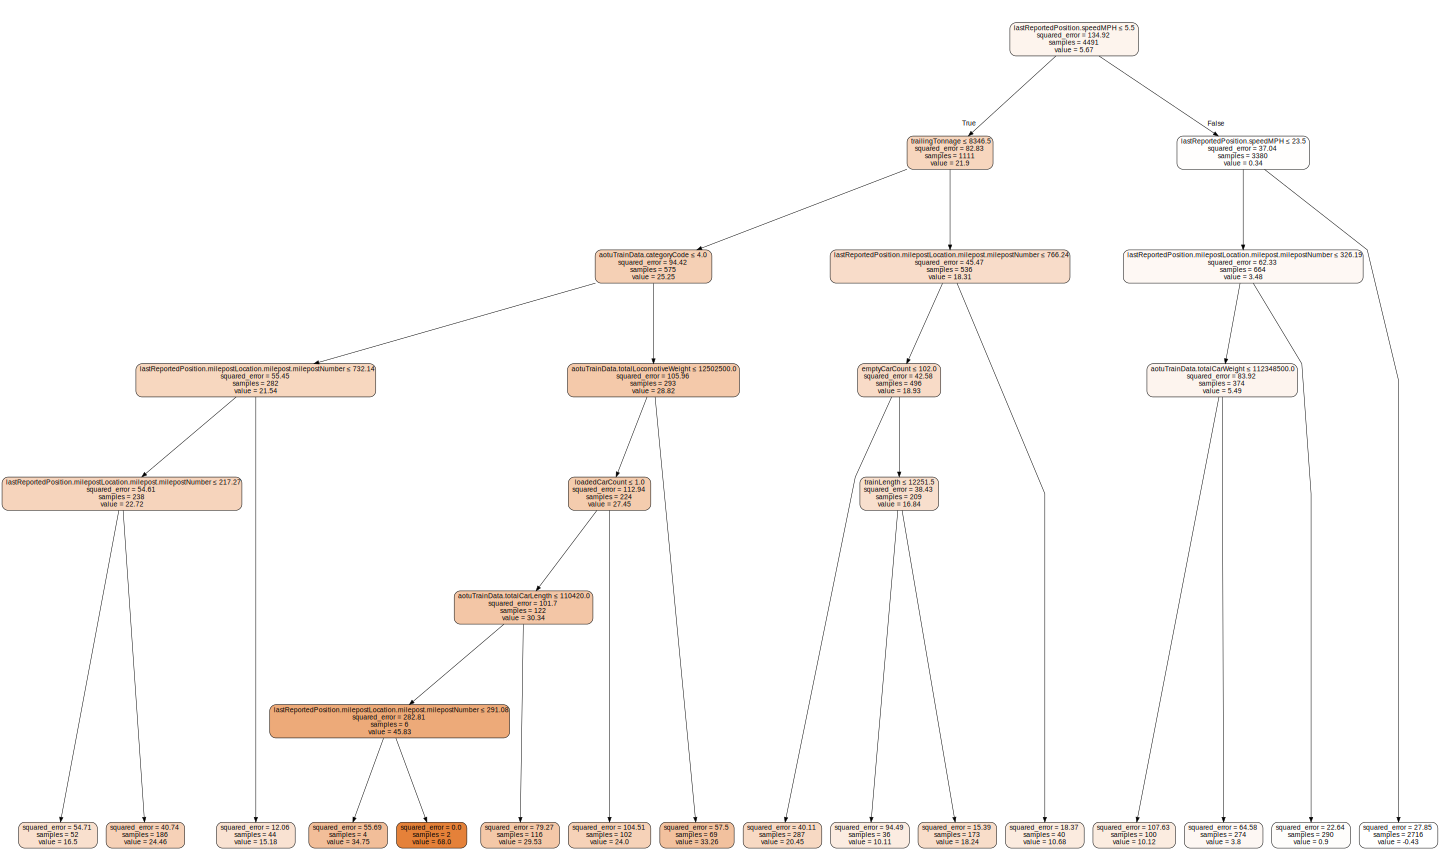

In [79]:
fastai.draw_tree(m, xs, size=20, leaves_parallel=True, precision=2)

In [80]:
m = DecisionTreeRegressor(min_samples_leaf=10)
m.fit(xs, y);

In [81]:
def r_mse(pred,y): return round(math.sqrt(((pred-y)**2).mean()), 6)
def m_rmse(m, xs, y): return r_mse(m.predict(xs), y)

In [82]:
m_rmse(m, xs, y)

4.620441

In [83]:
m_rmse(m, valid_xs, valid_y)

7.127803

In [84]:
def rf_feat_importance(m, df):
    return pd.DataFrame({'cols':df.columns, 'imp':m.feature_importances_}
                       ).sort_values('imp', ascending=False)

In [85]:
fi = rf_feat_importance(m, xs)
fi[:10]

,cols,imp
22,lastReportedPosition.speedMPH,0.789211
23,lastReportedPosition.milepostLocation.milepost.milepostNumber,0.056422
37,trailingTonnage,0.032957
8,aotuTrainData.categoryCode,0.015121
38,milepost,0.012828
24,aotuTrainData.totalCarWeight,0.012367
36,trainLength,0.012294
0,ptcLeadLocomotiveId,0.009812
45,lastReportedPosition.positionTimeElapsed,0.008606
34,loadedCarCount,0.008574


Our first result! It appears the previous speed is so heavily influencing the next speed, it swamps everything else.

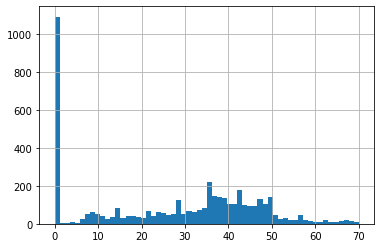

In [86]:
ax = xs['lastReportedPosition.speedMPH'].hist(bins=60)


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_partial_dependence is deprecated; Function `plot_partial_dependence` is deprecated in 1.0 and will be removed in 1.2. Use PartialDependenceDisplay.from_estimator instead
  warnings.warn(msg, category=FutureWarning)


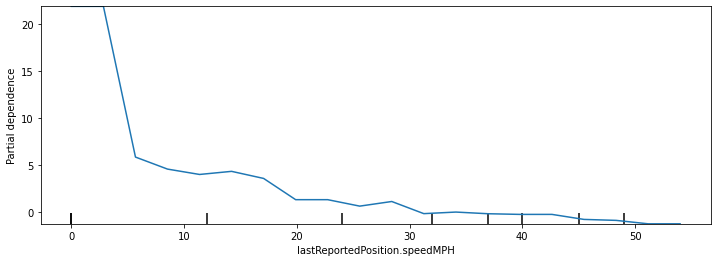

In [87]:
from sklearn.inspection import plot_partial_dependence

fig,ax = plt.subplots(figsize=(12, 4))
plot_partial_dependence(m, xs, ['lastReportedPosition.speedMPH'],
                        grid_resolution=20, ax=ax);

This is sort of a dur moment, saying "Speeds don't change a lot one milepost to the next".  

#Random Forest

In [88]:
def randomForest(xs, y, n_estimators=50, max_samples=2500,
       max_features=0.5, min_samples_leaf=5, **kwargs):
    return RandomForestRegressor(n_jobs=-1, n_estimators=n_estimators,
        max_samples=max_samples, max_features=max_features,
        min_samples_leaf=min_samples_leaf, oob_score=True).fit(xs, y)

In [89]:
m = randomForest(xs, y);

In [90]:
m_rmse(m, xs, y), m_rmse(m, valid_xs, valid_y)

(4.558093, 6.121021)

In [ ]:
preds = np.stack([t.predict(valid_xs) for t in m.estimators_])

In [92]:
r_mse(preds.mean(0), valid_y)

6.121021

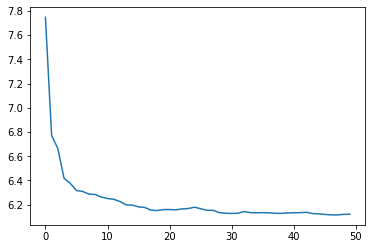

In [93]:
plt.plot([r_mse(preds[:i+1].mean(0), valid_y) for i in range(50)]);

### Out-of-Bag Error

In [94]:
r_mse(m.oob_prediction_, y)

5.686015

- How confident are we in our predictions using a particular row of data?
- For predicting with a particular row of data, what were the most important factors, and how did they influence that prediction?
- Which columns are the strongest predictors, which can we ignore?
- Which columns are effectively redundant with each other, for purposes of prediction?
- How do predictions vary, as we vary these columns?


In [ ]:
preds = np.stack([t.predict(valid_xs) for t in m.estimators_])

In [96]:
preds.shape

(50, 1759)

In [97]:
preds_std = preds.std(0)

In [98]:
preds_std[:5]

array([3.72025825, 3.79971699, 4.43113412, 4.89583075, 2.7140135 ])

In [99]:
print(preds.mean(0)[:10])
print(valid_y[:10])

[ 3.47941586  1.33453968  2.7391488  15.20062049  0.78575475  2.34304362  1.17933494  0.87676845  0.14703058 15.44956571]
1      8.0
2      5.0
10     4.0
11    13.0
15    -1.0
17     2.0
29     1.0
31    -1.0
55    -3.0
56     7.0
Name: nextSpeed, dtype: float32


# FEATURE Importance

In [100]:
fi = rf_feat_importance(m, xs)
fi[:20]

,cols,imp
22,lastReportedPosition.speedMPH,0.698110
12,mpIncr,0.051688
23,lastReportedPosition.milepostLocation.milepost.milepostNumber,0.039811
38,milepost,0.031218
37,trailingTonnage,0.021189
34,loadedCarCount,0.013810
45,lastReportedPosition.positionTimeElapsed,0.013132
8,aotuTrainData.categoryCode,0.012198
3,trainId.trainSymbol,0.010756
35,emptyCarCount,0.010540


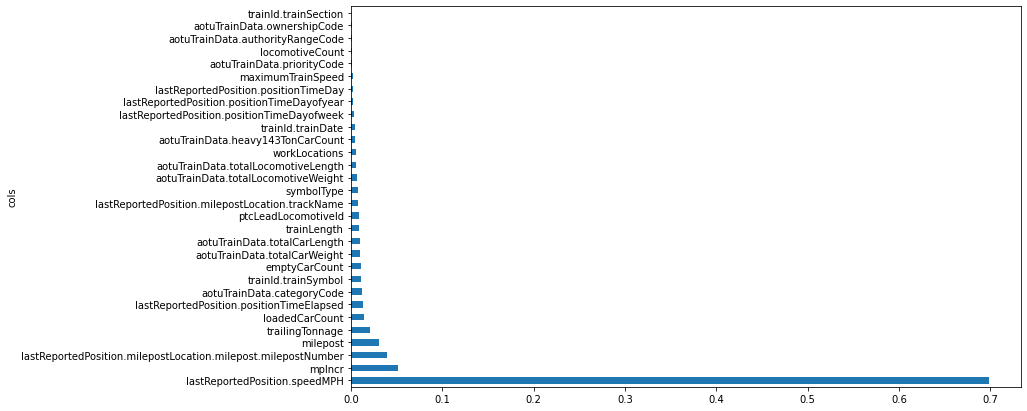

In [101]:
def plot_fi(fi):
    return fi.plot('cols', 'imp', 'barh', figsize=(12,7), legend=False)

plot_fi(fi[:30]);

Remove low importance columns

In [102]:
to_keep = fi[fi.imp>0.002].cols
len(to_keep)

25

In [103]:
xs_imp = xs[to_keep]
valid_xs_imp = valid_xs[to_keep]

In [104]:
m = randomForest(xs_imp, y)

In [105]:
m_rmse(m, xs_imp, y), m_rmse(m, valid_xs_imp, valid_y)

(4.567808, 6.150364)

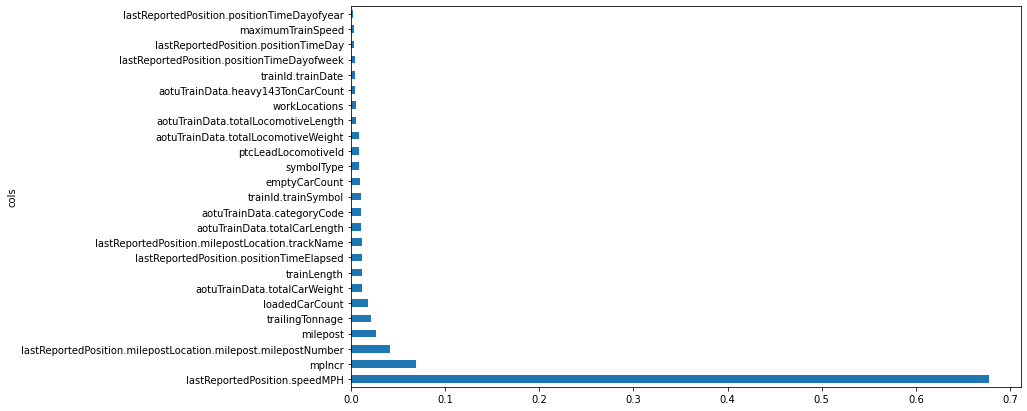

In [106]:
plot_fi(rf_feat_importance(m, xs_imp));

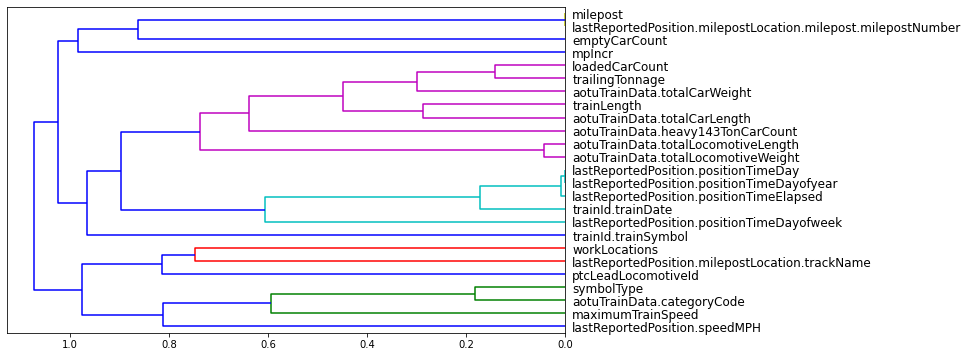

In [107]:
fastai.cluster_columns(xs_imp)

# Compute the Physics Model loss for the same interval:

In [108]:
b = dfTrainsNextBeop.tail(14165)
# beopValues = beopValues.to_frame().join(valid_y)
#m_rmse(m, valid_xs_imp, valid_y)
b = b.reset_index(drop=true)
#print (b)
y = valid_y.reset_index(drop=true)
#print (y)
df2  = pd.concat([b, y], axis=1)
df2.dropna()
print(df2)
r_mse(df2['nextBeop'], df2['nextSpeed'])
# print(BeopValidations[:5])
#print(valid_y[:5])

      nextBeop  nextSpeed
0          NaN        8.0
1          NaN        5.0
2          NaN        4.0
3          NaN       13.0
4          NaN       -1.0
...        ...        ...
6245      10.0        NaN
6246       NaN        NaN
6247       9.0        NaN
6248      -1.0        NaN
6249      -1.0        NaN

[6250 rows x 2 columns]


12.939125

# Finding Out-of-Domain Data
Spot variables that are unique to the test set versus the training set

In [109]:
df_dom = pd.concat([xs, valid_xs])
is_valid = np.array([0]*len(xs) + [1]*len(valid_xs))

m = randomForest(df_dom, is_valid)
rf_feat_importance(m, df_dom)[:8]

,cols,imp
44,lastReportedPosition.positionTimeDayofyear,0.516475
45,lastReportedPosition.positionTimeElapsed,0.346753
42,lastReportedPosition.positionTimeDay,0.073732
41,lastReportedPosition.positionTimeWeek,0.032330
4,trainId.trainDate,0.020432
43,lastReportedPosition.positionTimeDayofweek,0.005574
40,lastReportedPosition.positionTimeMonth,0.002522
19,lastReportedPosition.positionTimeIs_quarter_start,0.002181


This all makes sense

#Using a Neural Net

In [110]:
df_nn_final = dfTrainsLearn

In [111]:
df_nn_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6250 entries, 1 to 6746
Data columns (total 47 columns):
 #   Column                                                         Non-Null Count  Dtype         
---  ------                                                         --------------  -----         
 0   ptcLeadLocomotiveId                                            6250 non-null   object        
 1   trainId.trainSCAC                                              6250 non-null   category      
 2   trainId.trainSection                                           6250 non-null   category      
 3   trainId.trainSymbol                                            6250 non-null   object        
 4   trainId.trainDate                                              6250 non-null   datetime64[ns]
 5   lastReportedPosition.speedMPH                                  6250 non-null   int64         
 6   lastReportedPosition.milepostLocation.subdivisionId            6250 non-null   int64         
 7

In [112]:
cont_nn,cat_nn = cont_cat_split(df_nn_final, max_card=9000, dep_var=dep_var)

In [113]:
cont_nn

['lastReportedPosition.milepostLocation.milepost.milepostNumber',
 'aotuTrainData.totalCarWeight',
 'aotuTrainData.totalCarLength',
 'aotuTrainData.totalLocomotiveWeight',
 'aotuTrainData.totalLocomotiveLength',
 'aotuTrainData.actualTonsPerAxle',
 'aotuTrainData.heavy143TonCarCount',
 'aotuTrainData.heavy158TonCarCount',
 'aotuTrainData.over158TonCarCount',
 'aotuTrainData.highWideCarCount',
 'maximumTrainSpeed',
 'loadedCarCount',
 'emptyCarCount',
 'trainLength',
 'trailingTonnage',
 'lastReportedPosition.positionTimeElapsed']

In [114]:
numUniquePerCat = df_nn_final[cat_nn].nunique()
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  
    print(numUniquePerCat)

ptcLeadLocomotiveId                                    543
trainId.trainSCAC                                        1
trainId.trainSection                                     5
trainId.trainSymbol                                    180
trainId.trainDate                                       19
lastReportedPosition.speedMPH                           71
lastReportedPosition.milepostLocation.subdivisionId      1
lastReportedPosition.milepostLocation.trackName         14
aotuTrainData.priorityCode                               5
aotuTrainData.categoryCode                              15
aotuTrainData.authorityRangeCode                         4
aotuTrainData.ownershipCode                              3
aotuTrainData.eventCode                                  1
milepost                                               226
mpIncr                                                   2
symbolType                                              15
workLocations                                           

In [115]:
procs_nn = [Categorify, FillMissing, Normalize]
to_nn = TabularPandas(df_nn_final, procs_nn, cat_nn, cont_nn,
                      splits=splits, y_names=dep_var)

In [116]:
dls = to_nn.dataloaders(1024)

In [117]:
y = to_nn.train.y
y.min(),y.max()

(-39.0, 68.0)

In [118]:
learn = tabular_learner(dls, y_range=(-49,68), layers=[500,250],
                        n_out=1, loss_func=F.mse_loss)

SuggestedLRs(valley=0.0002290867705596611)

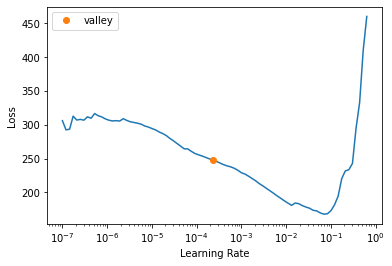

In [119]:
learn.lr_find()

In [120]:
learn.fit_one_cycle(50, 1e-3)

epoch,train_loss,valid_loss,time
0,264.118347,137.054993,00:00
1,232.288452,137.062241,00:00
2,210.842896,135.983658,00:00
3,194.190933,132.618332,00:00
4,182.715240,129.256042,00:00
5,168.801544,125.603287,00:00
6,155.036591,117.845100,00:00
7,140.708694,101.619034,00:00
8,127.870071,87.263374,00:00
9,116.561913,81.627594,00:00


In [121]:
preds,targs = learn.get_preds()
print(r_mse(preds,targs))
print(preds[:10])
print(targs[:10])

6.974727
tensor([[ 6.8369],
        [ 0.6896],
        [ 3.5540],
        [13.2466],
        [ 4.2007],
        [ 4.9295],
        [ 7.8509],
        [ 5.6346],
        [ 4.6276],
        [15.7666]])
tensor([[ 8.],
        [ 5.],
        [ 4.],
        [13.],
        [-1.],
        [ 2.],
        [ 1.],
        [-1.],
        [-3.],
        [ 7.]])
